In [25]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [26]:
m0 = np.array([5000, -20, 5000, 20])
P0 = np.diag([2000**2, 20 **2, 2000**2, 20**2])
c = 2
n = 200
dt = 1

H = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])
sigmaY1=0.1 * 20
sigmaY2=0.1 *1*np.pi/180
sigmaY=[sigmaY1, sigmaY2]
R = np.diag(sigmaY)
#R = np.diag([2500, 2500])


F = np.array([[1, dt, 0, 0], [0, 1, 0, 0], [0, 0, 1, dt], [0, 0, 0, 1]])
G = np.array([[dt**2 / 2, 0], [dt, 0], [0 , dt**2/ 2], [0, dt]])

In [27]:
def simu_etat(dt, n , m0, c, P0, F, G):
    # generation de X0
    X = []
    X.append(np.transpose(np.random.multivariate_normal( m0, P0, 1)))
    #print(X[0])
    EPSILON = []
    for i in range(n):
        EPSILON.append(np.transpose(np.random.multivariate_normal(np.array([0,0]),  c**2 * np.identity(2), 1)))
    #return(EPSILON)

    for k in range(1, n+ 1):
        #print(np.dot(F , X[k-1]))
        #print(np.dot(G , EPSILON[k-1]))
        X.append(np.dot(F , X[k-1]) + np.dot(G , EPSILON[k-1]))
    return(X)


In [28]:
def h(X):
    "Fonction h de la mesure de la position"
    x=X[0]
    y=X[2]
    if x >0:
        return np.array([x**2+y**2, np.arctan(y/x)])
    else:
        if y >0:
            return np.array([x**2+y**2, np.arctan(y/x)+np.pi])
        else:
            return np.array([x**2+y**2, np.arctan(y/x)-np.pi])


In [29]:
def SimuObs_etendu(X, R):
    n = len(X)  # attention vaut 201
    # generate Vk
    V = []
    for i in range(n ):
        V.append(np.transpose(np.random.multivariate_normal( [0,0], R, 1)))
    Y = []
    for k in range(n) : 
        Y.append(h(X[k]) + V[k])
        
    return(Y)

/var/folders/p6/zjx2n73n5n3dsn9j2q4j2t900000gn/T/ipykernel_70296/443734325.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.plot([float(res[0]) for res in X], [float(res[2]) for res in X] , color = 'blue')


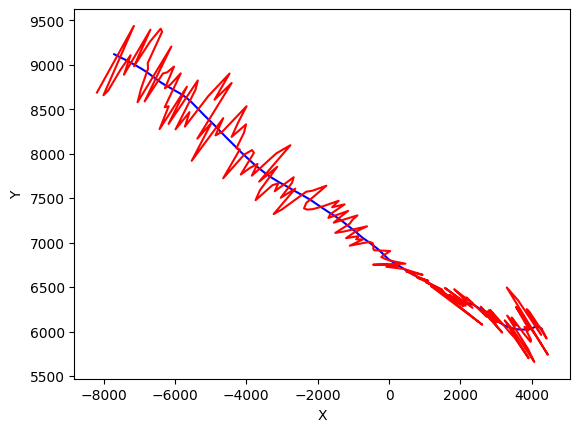

In [30]:
X = simu_etat(dt, n , m0, c, P0, F, G)
Y =  SimuObs_etendu(X, R)

def cartesien(Y):
    "Renvoie la position cartésienne à partir des coordonnées polaires"
    return [np.sqrt(Y[i][0])*np.cos(Y[i][1]) for i in range(len(Y))], [np.sqrt(Y[i][0])*np.sin(Y[i][1]) for i in range(len(Y))]

ya, yb = cartesien(Y)


plt.plot([float(res[0]) for res in X], [float(res[2]) for res in X] , color = 'blue')
plt.plot(ya, yb, color = 'red' )

plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [31]:
def grad_h(X):
    "Fonction différentielle associée à h"
    x=X[0]
    y=X[2]
    res=np.zeros((2,4))
    res[0,0]=2*x
    res[0,2]=2*y
    res[1,0]=-y/(x**2+y**2)
    res[1,2]=1/(x* (x**2+y**2))
    return res

In [32]:
def Kalman_etendu(Y, F, G, m0, P0, c, H, R):
    n = len(Y)
    X_corr = [np.array(X[0])]
    P_corr = [P0]
    X_pred = []
    P_pred = []
     
    for i in range(n-1):
        # prediction
       
       # prediction en change pas 
        X_pred.append((F @ X_corr[-1]))
        P_pred.append(F @ P_corr[-1] @ F.T + G @ np.diag([c**2, c**2]) @ G.T)

        # calcul de la matrice de gain
        #print("X_pred :", X_pred)
        inverse = np.linalg.inv(grad_h(X_pred[i]) @ P_pred[i] @ grad_h(X_pred[i]).T + R)
        K = P_pred[i] @ (grad_h(X_pred[i])).T @ inverse
        
        # correction        
        X_corr.append(X_pred[i] + K @ (Y[i] - h(X_pred[i])))
        #print("X_corr : ", X_corr)

        P_corr.append((np.identity(4) - K @ grad_h(X_pred[i])) @ P_pred[i])

    return(X_pred, P_pred, X_corr, P_corr)

/var/folders/p6/zjx2n73n5n3dsn9j2q4j2t900000gn/T/ipykernel_70296/1076358085.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res[0,0]=2*x
/var/folders/p6/zjx2n73n5n3dsn9j2q4j2t900000gn/T/ipykernel_70296/1076358085.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res[0,2]=2*y
/var/folders/p6/zjx2n73n5n3dsn9j2q4j2t900000gn/T/ipykernel_70296/1076358085.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res[1,0]=-y/(x**2+y**2)
/var/folders/p6/zjx2n73n5n3dsn9j2q4

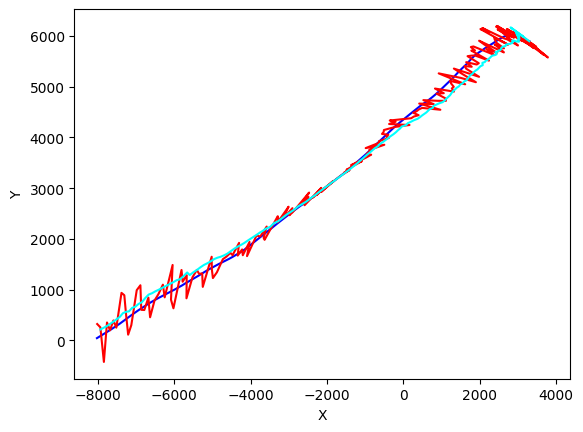

In [38]:
X = simu_etat(dt, n , m0, c, P0, F, G)
Y =  SimuObs_etendu(X, R)
ya, yb = cartesien(Y)
X_PRED, P_PRED, X_corr, P_corr = Kalman_etendu(Y, F, G, m0, P0, c, H, R)



plt.plot([float(res[0]) for res in X], [float(res[2]) for res in X] , color = 'blue')
plt.plot(ya, yb, color = 'red' )
#plt.plot( [float(res[0]) for res in X_PRED], [float(res[2]) for res in X_PRED], color = 'green' )
plt.plot([float(res[0]) for res in X_corr], [float(res[2]) for res in X_corr], color = 'cyan' )


plt.xlabel("X")
plt.ylabel("Y")
plt.show()